### DSML investigation

You are part of the Suisse Impossible Mission Force, or SIMF for short. You need to uncover a rogue agent that is trying to steal sensitive information.

Your mission, should you choose to accept it, is to find that agent before stealing any classified information. Good luck!

# Assignment part five

More information came in that suggests that the rogue agent is tampering with the sentiment annotation system of the SIMF which analyses news documents and marks their sentiment for intelligence analysis tasks.

This annotation is crucial to identify documents expressing negativity towards Switzerland and its allies.

Each document contains a column which shows which user accessed it. We know that the rogue agent accessed only the documents whose negative sentiment was high, and then changed them to positive or neutral. We will use a huggingface model to identify which records have been tampered with.


[You can find more models on this link](https://huggingface.co/models?sort=trending)


In [ ]:
# Install the required libraries (you need to run this cell ONLY if you are running the notebook locally)
# No need to run this cell in colab!
%%capture
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs
!pip install transformers[torch]
!pip install accelerate -U
!pip install openpyxl

!pip install -q transformers
%pip install ipywidgets
%pip install --upgrade transformers huggingface_hub torch



In [ ]:
# Import required packages
from transformers import pipeline, DataCollatorWithPadding
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split

torch.cuda.is_available()

# Import standard libraries
import pandas as pd
import numpy as np
import math
import bs4 as bs
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Import for text analytics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# Import metrics libraries
from sklearn.metrics import confusion_matrix, accuracy_score



# 1. Getting to know our data

In [ ]:

df = pd.read_excel('https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Assignements/Part%205/data/Reduced_Set_2100.xlsx')

In [20]:
df.head(2)

,company,title,news,evaluation,year,month,day,Title_Sentiment_Probabilities
0,APPLE,Tourists snap up British iPads to smuggle into...,IT'S the digital version of the slow boat to C...,negative,2011,4,17,None
1,CHEVRON,AFTER SEATTLE; Anarchists get organized.,"For Juliette Beck, it began with the story of ...",negative,2000,4,17,None


### 2. Re-evaluating with SIMF's Model

We will re-evaluate the sentiment on the `title` column using a sentiment analysis pipeline based on the `finiteautomata/bertweet-base-sentiment-analysis` model. This is a sentiment analysis model trained on ~40k tweets. It classifies a text as `POS` (positive), `NEU` (neutral), or `NEG` (negative) sentiment.

Initialize a sentiment analysis classifier with the pre-trained model mentioned above, making sure to set the correct value for the `task` parameter.

**Note**: Set the `top_k` argument to `None` to retrieve the probabilities for all possible sentiment labels in the output.

_This process may take some time._

In [21]:
from transformers import pipeline
import pandas as pd

# Step 1: Initialize the sentiment analysis pipeline
sentiment_analyzer = pipeline(
    task="text-classification",
    model="finiteautomata/bertweet-base-sentiment-analysis",
    top_k=None  # Retrieve probabilities for all sentiment labels (NEG, NEU, POS)
)

# Step 2: Define a function to extract sentiment probabilities for each title
def get_sentiment_probabilities(title):
    result = sentiment_analyzer(title)
    print(result)  # Print result to check its structure
    if isinstance(result, list) and all(isinstance(entry, dict) for entry in result):
        # Expected case: result is a list of dictionaries
        return {entry['label']: entry['score'] for entry in result}
    elif isinstance(result, dict):  # If a single dictionary is returned
        return {result['label']: result['score']}
    else:
        return None  # Handle any unexpected format

# Step 3: Apply the function to each title in the 'title' column
df['Title_Sentiment_Probabilities'] = df['title'].apply(get_sentiment_probabilities)

# Display the DataFrame with the new sentiment probabilities column
df[['title', 'Title_Sentiment_Probabilities']].head()


[[{'label': 'NEU', 'score': 0.8835569620132446}, {'label': 'NEG', 'score': 0.0922793447971344}, {'label': 'POS', 'score': 0.024163736030459404}]]
[[{'label': 'NEU', 'score': 0.966677725315094}, {'label': 'POS', 'score': 0.02316223829984665}, {'label': 'NEG', 'score': 0.010159943252801895}]]
[[{'label': 'NEG', 'score': 0.8902711272239685}, {'label': 'NEU', 'score': 0.10649044066667557}, {'label': 'POS', 'score': 0.003238446544855833}]]
[[{'label': 'POS', 'score': 0.6151900887489319}, {'label': 'NEU', 'score': 0.37382176518440247}, {'label': 'NEG', 'score': 0.010988101363182068}]]
[[{'label': 'NEU', 'score': 0.5660677552223206}, {'label': 'POS', 'score': 0.4308086037635803}, {'label': 'NEG', 'score': 0.0031236319337040186}]]
[[{'label': 'NEU', 'score': 0.5547481179237366}, {'label': 'NEG', 'score': 0.4380112588405609}, {'label': 'POS', 'score': 0.007240646053105593}]]
[[{'label': 'NEU', 'score': 0.9580365419387817}, {'label': 'POS', 'score': 0.03336634859442711}, {'label': 'NEG', 'score'

,title,Title_Sentiment_Probabilities
0,Tourists snap up British iPads to smuggle into...,None
1,AFTER SEATTLE; Anarchists get organized.,None
2,$10bn oil payout voided,None
3,Craft capitalism: Just do it yourself; Web mar...,None
4,Chevron gas project gets state green light,None


Apply the sentiment classifier to the `title` column and assign the corresponding sentiment labels to a new column in your dataframe.

Make sure to convert the sentiment labels from the model by replacing them with more descriptive terms like this:
- **NEU**: neutral
- **NEG**: negative
- **POS**: positive

*Hint: Be mindful of the format of the classifier’s output.*

_Beware that applying the model on all of the rows may take some time_

In [24]:
from transformers import pipeline
import pandas as pd

# Initialize the sentiment analysis pipeline without specifying `top_k`
sentiment_analyzer = pipeline(
    task="text-classification",
    model="finiteautomata/bertweet-base-sentiment-analysis"
)

# Define label mapping
label_mapping = {'NEU': 'neutral', 'NEG': 'negative', 'POS': 'positive'}

# Function to apply the classifier and map labels to descriptive terms
def assign_descriptive_label(title):
    result = sentiment_analyzer(title)
    print(result)  # Print result for inspection
    if isinstance(result, list) and len(result) > 0 and 'label' in result[0]:
        # Extract the highest-probability label and map it
        model_label = result[0]['label']
        descriptive_label = label_mapping.get(model_label, model_label)  # Map to descriptive term
        return descriptive_label
    return None  # Return None if output is not as expected

# Apply the function to each row in the 'title' column
df['Descriptive_Sentiment_Label'] = df['title'].apply(assign_descriptive_label)

# Display the DataFrame with the new column
df[['title', 'Descriptive_Sentiment_Label']].head()

[{'label': 'NEU', 'score': 0.8835569620132446}]
[{'label': 'NEU', 'score': 0.966677725315094}]
[{'label': 'NEG', 'score': 0.8902711272239685}]
[{'label': 'POS', 'score': 0.6151900887489319}]
[{'label': 'NEU', 'score': 0.5660677552223206}]
[{'label': 'NEU', 'score': 0.5547481179237366}]
[{'label': 'NEU', 'score': 0.9580365419387817}]
[{'label': 'POS', 'score': 0.7927179336547852}]
[{'label': 'NEU', 'score': 0.9371843934059143}]
[{'label': 'NEU', 'score': 0.8277260065078735}]
[{'label': 'NEU', 'score': 0.6276261806488037}]
[{'label': 'NEU', 'score': 0.9732624888420105}]
[{'label': 'NEG', 'score': 0.8498765826225281}]
[{'label': 'NEG', 'score': 0.9590968489646912}]
[{'label': 'NEG', 'score': 0.9412946701049805}]
[{'label': 'NEU', 'score': 0.9211557507514954}]
[{'label': 'NEU', 'score': 0.7569046020507812}]
[{'label': 'NEU', 'score': 0.8150340914726257}]
[{'label': 'NEU', 'score': 0.9391776323318481}]
[{'label': 'NEU', 'score': 0.9599577188491821}]
[{'label': 'NEU', 'score': 0.937106609344

,title,Descriptive_Sentiment_Label
0,Tourists snap up British iPads to smuggle into...,neutral
1,AFTER SEATTLE; Anarchists get organized.,neutral
2,$10bn oil payout voided,negative
3,Craft capitalism: Just do it yourself; Web mar...,positive
4,Chevron gas project gets state green light,neutral


Now, display the number of unique sentiment evaluations for both the Hugging Face and SIMF models to compare the distribution of labels.

Next, calculate and display the accuracy of the Hugging Face sentiment analysis compared to the SIMF evaluation. Finally, visualize the comparison using a heatmap of the confusion matrix to better understand where the two models align or differ.

In [25]:
print("Unique sentiment counts for the Hugging Face model:")
print(df['Descriptive_Sentiment_Label'].value_counts())

print("\nUnique sentiment counts for the SIMF model (evaluation):")
print(df['evaluation'].value_counts())

Unique sentiment counts for the Hugging Face model:
Descriptive_Sentiment_Label
neutral     1380
negative     384
positive     336
Name: count, dtype: int64

Unique sentiment counts for the SIMF model (evaluation):
evaluation
negative    700
neutral     700
positive    700
Name: count, dtype: int64


Accuracy of Hugging Face model compared to SIMF evaluation: 0.43


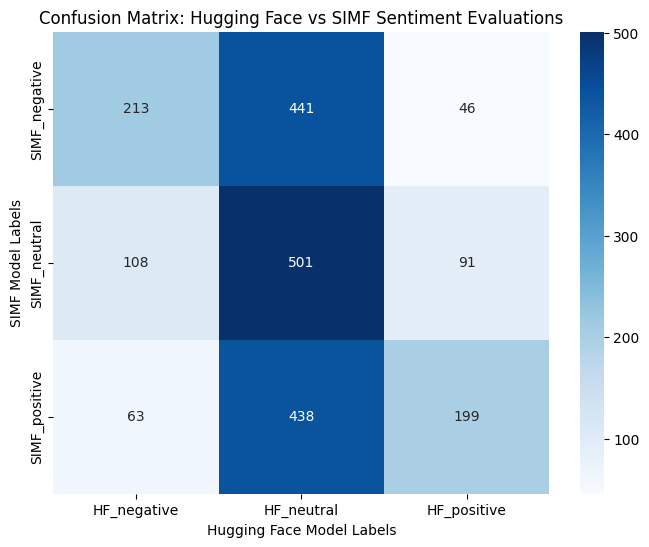

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the accuracy between Hugging Face and SIMF sentiment labels
accuracy = accuracy_score(df['evaluation'], df['Descriptive_Sentiment_Label'])
print(f"Accuracy of Hugging Face model compared to SIMF evaluation: {accuracy:.2f}")

# Generate a confusion matrix
conf_matrix = confusion_matrix(df['evaluation'], df['Descriptive_Sentiment_Label'], labels=['negative', 'neutral', 'positive'])

# Convert to a DataFrame for better readability in the heatmap
conf_matrix_df = pd.DataFrame(conf_matrix, index=['SIMF_negative', 'SIMF_neutral', 'SIMF_positive'],
                              columns=['HF_negative', 'HF_neutral', 'HF_positive'])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title("Confusion Matrix: Hugging Face vs SIMF Sentiment Evaluations")
plt.xlabel("Hugging Face Model Labels")
plt.ylabel("SIMF Model Labels")
plt.show()

In [ ]:
# Your code here


**Q1. Does the SIMF sentiment classifier predicts more samples to be "neutral"  compared to the Hugging Face sentiment classifier?**

No, the SIMF sentiment classifier does not predict more samples to be "neutral" compared to the Hugging Face sentiment classifier bc Huggin = 1380 and SIMF = 700


## 2.1 Entries match both the SIMF model **and** the hugginface model

The SIMF model values are found in the `evaluation` column, while the hugginface model values should be found in the `new_column`, which you added to the table in the previous step.

Display:
*   The rows/records with same sentiment for both models.
*   The number of matching values.
*   The share of matching values of the total number of values.



In [27]:
# Step 1: Filter rows where the sentiment labels from both models match
matching_rows = df[df['evaluation'] == df['Descriptive_Sentiment_Label']]

# Step 2: Display rows where the sentiment labels match
print("Rows with the same sentiment for both models:")
print(matching_rows)

# Step 3: Count the number of matching rows
num_matching = len(matching_rows)
print(f"\nNumber of matching values: {num_matching}")

# Step 4: Calculate the percentage of matching values
total_rows = len(df)
matching_percentage = (num_matching / total_rows) * 100
print(f"Share of matching values: {matching_percentage:.2f}%")

Rows with the same sentiment for both models:
                      company  \
2                 Exxon Mobil   
12                  MICROSOFT   
13                    PEPSICO   
14                Exxon Mobil   
23                Exxon Mobil   
...                       ...   
2087                COCA COLA   
2094                CITIGROUP   
2097          WAL MART STORES   
2098         GENERAL ELECTRIC   
2099  INTERNATIONAL BUS.MCHS.   

                                                  title  \
2                               $10bn oil payout voided   
12    Greenpeace slams Microsoft, Nintendo's 'toxic'...   
13                                      PESTICIDE PANIC   
14    High-cost oil projects may be wasted, report says   
23                 MORE TOXIC SLUDGE FEARED IN WATERWAY   
...                                                 ...   
2087  You said it, earthlings: WE WANT CHANGE; EARTH...   
2094          HOMETOWN CEO LIKES WHAT HE SEES IN LENNAR   
2097                 Unile

**Q2. How many entries are identical between the SIMF model evaluation and the Hugging Face model evaluation?**

*Note: Provide your answer as an integer (e.g., 80).*

Rows with Matching Sentiments: The Hugging Face and SIMF models classified the sentiment identically for 913 rows in the dataset.Matching Percentage: This represents 43.48% of the total dataset, meaning that in nearly half of the cases, the models agreed on the sentiment classification.



## 2.2 Entries that do not match both models
Identify all non matching entries.

Create a subset with all the entries that were evaluated differently by the two models.

In [29]:
non_matching_rows = df[df['evaluation'] != df['Descriptive_Sentiment_Label']]

# Step 2: Display the subset with all non-matching entries
print("Rows with different sentiment evaluations between the two models:")
print(non_matching_rows)

# Optionally, check the number of non-matching rows and the share of total rows
num_non_matching = len(non_matching_rows)
print(f"\nNumber of non-matching values: {num_non_matching}")

# Percentage of non-matching entries out of the total dataset
total_rows = len(df)
non_matching_percentage = (num_non_matching / total_rows) * 100
print(f"Share of non-matching values: {non_matching_percentage:.2f}%")

Rows with different sentiment evaluations between the two models:
               company                                              title  \
0               APPLE   Tourists snap up British iPads to smuggle into...   
1              CHEVRON           AFTER SEATTLE; Anarchists get organized.   
3      WAL MART STORES  Craft capitalism: Just do it yourself; Web mar...   
4          Exxon Mobil         Chevron gas project gets state green light   
5              CHEVRON                              RIVALS WILL ACCUSE BP   
...                ...                                                ...   
2091           PEPSICO                                        At Deadline   
2092            PFIZER            TAKING UP THE ISSUE OF RENEWABLE ENERGY   
2093  GENERAL ELECTRIC  Virgin Atlantic gives $8bn order to Boeing in ...   
2095           CHEVRON  No twig left behind; Old into new. Wood waste ...   
2096     CISCO SYSTEMS        Video Calls Replacing Face-to-Face Meetings   

         

## 2.3 Predicted negative, but evaluated as neutral or positive by the SIMF model

Remember, we are looking at document that were tempered (altered). We suspect that the rogue agent accessed only the documents whose negative sentiment was high, and was then changed to positive or neutral.

Create a subset with only those values, which appear as 'positive' or 'neutral' in the original `evaluation` column, but are marked as having a 'negative' sentiment by the new hugginface model.

**This subset is what we'll call the end of the assignment : "Altered Documents".**

In [30]:
altered_documents = df[(df['evaluation'].isin(['positive', 'neutral'])) & (df['Descriptive_Sentiment_Label'] == 'negative')]

# Step 2: Display the subset of altered documents
print("Altered Documents (evaluated as positive or neutral by SIMF, but predicted as negative by Hugging Face):")
print(altered_documents)

# Optionally, check the number of altered documents
num_altered_documents = len(altered_documents)
print(f"\nNumber of altered documents: {num_altered_documents}")

# Percentage of altered documents out of the total dataset
total_rows = len(df)
altered_percentage = (num_altered_documents / total_rows) * 100
print(f"Share of altered documents: {altered_percentage:.2f}%")

Altered Documents (evaluated as positive or neutral by SIMF, but predicted as negative by Hugging Face):
                      company  \
702           BANK OF AMERICA   
715    VERIZON COMMUNICATIONS   
722                 CITIGROUP   
733                 CITIGROUP   
738                 CITIGROUP   
...                       ...   
2032        JOHNSON & JOHNSON   
2034          MERCK & COMPANY   
2037          WAL MART STORES   
2053         GENERAL ELECTRIC   
2078  INTERNATIONAL BUS.MCHS.   

                                                  title  \
702   Letters: Anger simmers over energy bills; Thes...   
715      So How Contaminated Is the Old Nuclear Plant?    
722   Front: Carbon bubble 'creates global economic ...   
733   Report says officials are shortsighted big spe...   
738                 Miners to bear cost of climate toll   
...                                                 ...   
2032  Energy: Internet hoax raises pressure over emi...   
2034  TRENDS   RAIN-FOREST

**Q3. How many entries were changed from a negative evaluation (in the Hugging Face model) to a neutral or positive evaluation (by the SIMF model)?**

*Note: Provide your answer as an integer (e.g., 45).*


In [31]:
changed_from_negative = df[(df['Descriptive_Sentiment_Label'] == 'negative') & (df['evaluation'].isin(['neutral', 'positive']))]

# Display the subset of changed entries
print("Entries changed from negative (Hugging Face) to neutral or positive (SIMF):")
print(changed_from_negative)

# Count the number of changed entries
num_changed_from_negative = len(changed_from_negative)
print(f"\nNumber of entries changed from negative to neutral or positive: {num_changed_from_negative}")

Entries changed from negative (Hugging Face) to neutral or positive (SIMF):
                      company  \
702           BANK OF AMERICA   
715    VERIZON COMMUNICATIONS   
722                 CITIGROUP   
733                 CITIGROUP   
738                 CITIGROUP   
...                       ...   
2032        JOHNSON & JOHNSON   
2034          MERCK & COMPANY   
2037          WAL MART STORES   
2053         GENERAL ELECTRIC   
2078  INTERNATIONAL BUS.MCHS.   

                                                  title  \
702   Letters: Anger simmers over energy bills; Thes...   
715      So How Contaminated Is the Old Nuclear Plant?    
722   Front: Carbon bubble 'creates global economic ...   
733   Report says officials are shortsighted big spe...   
738                 Miners to bear cost of climate toll   
...                                                 ...   
2032  Energy: Internet hoax raises pressure over emi...   
2034  TRENDS   RAIN-FOREST CHIC   Maybe Ben & Jerry'...

# 3. Use the ChangeLog dataframe to identify the usersID's who edited the entries.

Consider the subset you created in the previous step : *the altered documents*.

By combining it with ChangeLog, display only those userIDs, that belong to the people who tried to mask the 'negative' sentiments by assigning these sentences a 'positive' or 'neutral' value.

In other words, match the previous subset with corresponding UserIDs.

In [32]:
ChangeLog = pd.read_csv('https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Assignements/Part%205/data/ChangeLogFix.csv')

In [33]:
display(ChangeLog.head(10))

,UserID,title
0,[327047],Tourists snap up British iPads to smuggle into...
1,[401818],Tourists snap up British iPads to smuggle into...
2,[564061],Tourists snap up British iPads to smuggle into...
3,[446376],Tourists snap up British iPads to smuggle into...
4,[242912],AFTER SEATTLE; Anarchists get organized.
5,[645264],AFTER SEATTLE; Anarchists get organized.
6,[654139],$10bn oil payout voided
7,[162287],$10bn oil payout voided
8,[682811],$10bn oil payout voided
9,[910568],Craft capitalism: Just do it yourself; Web mar...


In [ ]:
# Your code here


**Q4. Which of the following users remain suspects when considering only the documents evaluated as negative by the Hugging Face model but not by the SIMF model?**

*Note: Select among the following answers*

### 4. Identifying Key Information in the Altered Documents

In this section, we will use the **TF-IDF** (Term Frequency-Inverse Document Frequency) features to identify significant terms in the *altered documents*.

Start by creating a list of all the original texts from the `news` column in the dataframe `df`.


In [34]:
# Step 1: Extract all texts from the 'news' column into a list
news_texts = df['news'].tolist()

# Display the first few entries to confirm
print("Sample texts from the 'news' column:")
print(news_texts[:5])  # Display the first 5 entries as a sample

Sample texts from the 'news' column:
["IT'S the digital version of the slow boat to China. The iPad 2, made in China but yet to go on sale there, is being bought in London and smuggled back into the country where it is manufactured.  It means the Apple tablet is creating extra carbon emissions as it travels halfway across the world and back again. Customers are queuing to buy the iPad 2 at Apple shops in London and send them 6,000 miles back to China. The tablets are bought for their retail price of £399 for a 16GB model and then taken to China, where they sell for £430. The profit is not in this small mark-up but in the 20% Vat - in this case almost £80 - Chinese tourists can reclaim when they take the iPads out of the country. No tax is paid to the Chinese authorities by the smugglers. It means a student who takes home six iPads can fund his trip to London. […]", 'For Juliette Beck, it began with the story of the Ittu Oromo, Ethiopian nomads whose lives were destroyed, in vast number


Initialize the `TfidfVectorizer` with unigrams (`ngram_range=(1, 1)`) and set the `stop_words` parameter to `'english'` to exclude common English words from the analysis.


Apply the vectorizer to the corpus of text and convert the resulting document-term matrix into a DataFrame for easy visualization and analysis.


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Step 1: Filter the Altered Documents subset
# Assumes `df` contains both 'Descriptive_Sentiment_Label' and 'evaluation' columns
altered_documents = df[(df['Descriptive_Sentiment_Label'] == 'negative') & (df['evaluation'].isin(['neutral', 'positive']))]

# Step 2: Extract the 'news' column as a corpus of text
news_texts = altered_documents['news'].tolist()

# Step 3: Initialize the TfidfVectorizer with unigrams and stop words
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')

# Step 4: Apply the vectorizer to the text corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(news_texts)

# Step 5: Convert the TF-IDF matrix to a DataFrame
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Display the DataFrame for visualization and analysis
print("TF-IDF Document-Term Matrix for Altered Documents:")
print(tfidf_df.head())

TF-IDF Document-Term Matrix for Altered Documents:
   000  042   06  09bn   10      100  1000  104   11  112  ...  york  young  \
0  0.0  0.0  0.0   0.0  0.0  0.00000   0.0  0.0  0.0  0.0  ...   0.0    0.0   
1  0.0  0.0  0.0   0.0  0.0  0.00000   0.0  0.0  0.0  0.0  ...   0.0    0.0   
2  0.0  0.0  0.0   0.0  0.0  0.00000   0.0  0.0  0.0  0.0  ...   0.0    0.0   
3  0.0  0.0  0.0   0.0  0.0  0.00000   0.0  0.0  0.0  0.0  ...   0.0    0.0   
4  0.0  0.0  0.0   0.0  0.0  0.07496   0.0  0.0  0.0  0.0  ...   0.0    0.0   

   yuba  yvo  zealand  zedong  zero  ziggy  zone  zurich  
0   0.0  0.0      0.0     0.0   0.0    0.0   0.0     0.0  
1   0.0  0.0      0.0     0.0   0.0    0.0   0.0     0.0  
2   0.0  0.0      0.0     0.0   0.0    0.0   0.0     0.0  
3   0.0  0.0      0.0     0.0   0.0    0.0   0.0     0.0  
4   0.0  0.0      0.0     0.0   0.0    0.0   0.0     0.0  

[5 rows x 5362 columns]


We now want to focus solely on the **"altered documents"**.

To do this, use the previously created list that contains the documents where the Hugging Face model gave a **negative** evaluation, but the SIMF model evaluated them as **neutral** or **positive**.

From this list of documents, extract the corresponding text from the `news` column to obtain a list of articles.

In [36]:
# Step 1: Filter the altered documents subset
altered_documents = df[(df['Descriptive_Sentiment_Label'] == 'negative') & (df['evaluation'].isin(['neutral', 'positive']))]

# Step 2: Extract the 'news' column from this subset to obtain a list of articles
altered_news_texts = altered_documents['news'].tolist()

# Display the list of articles to verify the output
print("List of articles from the altered documents:")
print(altered_news_texts)

List of articles from the altered documents:
["[…] Ending our addiction to fossil fuels, slashing energy waste and developing the United Kingdom's huge renewable energy resources would not only provide us with an affordable energy system, it would also help combat the growing threat of climate change. Last month major financial institutions, including the BANK OF AMERICA and the insurance giant Aviva, accused the Government of scaring off investment in Britain's renewable energy sector because of its refusal to include a power-sector decarbonisation target in its Energy Bill. Many peers in the House of Lords are known to share this view, and look increasingly likely to reverse the Government's block on a decarbonisation target later this month. Faced with fresh scientific warnings about the impacts of climate change and the urgent need to fix our broken energy system the Government must drop its opposition to a clean power target. Andy Atkins, Executive Director,  Friends of the Earth,

Now, we will identify the document that stands out the most among the altered documents based on the TF-IDF values.

1. **Filter the TF-IDF DataFrame**: Keep only the entries from the `tfidf_df` that correspond to the tampered documents.
   
2. **Sum TF-IDF Values**: For each tampered document, calculate the sum of the TF-IDF values across all tokens. This gives an overall importance score for each document.

3. **Find the Most Significant Document**: Identify the document with the highest summed TF-IDF value, which stands out the most. Retrieve its index from the original DataFrame `df` and display the details of this document.

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Step 1: Ensure altered_documents subset is properly indexed
altered_documents = df[(df['Descriptive_Sentiment_Label'] == 'negative') & (df['evaluation'].isin(['neutral', 'positive']))]

# Extract the altered documents texts for TF-IDF (reinitializing for demonstration)
news_texts = altered_documents['news'].tolist()

# Initialize and apply the TF-IDF Vectorizer with unigrams and stop words
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(news_texts)

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Step 2: Calculate the sum of TF-IDF values across all tokens for each altered document
tfidf_df['tfidf_sum'] = tfidf_df.sum(axis=1)

# Step 3: Find the document with the highest summed TF-IDF value
max_tfidf_index = tfidf_df['tfidf_sum'].idxmax()

# Retrieve the details of this document from the original `altered_documents` DataFrame
most_significant_document = altered_documents.iloc[max_tfidf_index]

# Display the details of the most significant document
print("The most significant document among the altered documents:")
print(most_significant_document)

The most significant document among the altered documents:
company                                                           GENERAL ELECTRIC
title                            Force of Nature; Environmentalism is no longer...
news                             It seems like a hippie entrepreneur's dream co...
evaluation                                                                positive
year                                                                          2006
month                                                                            8
day                                                                             14
Title_Sentiment_Probabilities                                                 None
Descriptive_Sentiment_Label                                               negative
Name: 1761, dtype: object


**Q5. What is the name's company of the most important altered document?**

*Note: The most important altered document means the document with the highest summed TF-IDF value.*

General Electric

Now, across the altered documents, let's identify the words that stand out the most, meaning those with the highest summed TF-IDF values.

To achieve this, sum the values of each column in the altered TF-IDF dataframe, since each column represents a token. Then, sort these summed values in descending order to easily identify the top 4 words with the highest TF-IDF scores.

Once you have these top 4 words, count in how many *altered documents* each top word appeared.

In [40]:
# Step 1: Sum TF-IDF values for each word across all altered documents, excluding 'tfidf_sum'
word_sums = tfidf_df.drop(columns=['tfidf_sum'], errors='ignore').sum(axis=0)

# Step 2: Sort words by their summed TF-IDF scores in descending order
top_words = word_sums.sort_values(ascending=False).head(4)
print("Top 4 words with the highest TF-IDF scores:")
print(top_words)

# Step 3: Count the occurrence of each top word across the altered documents
# Convert to a DataFrame for better readability
top_words_df = pd.DataFrame(top_words, columns=['Total_TFIDF'])

# Add a column to count in how many documents each word appears
top_words_df['Document_Count'] = [tfidf_df[word].astype(bool).sum() for word in top_words.index]

# Display the results
print("\nTop 4 words and their occurrence count across altered documents:")
print(top_words_df)

Top 4 words with the highest TF-IDF scores:
said       5.882174
carbon     5.610031
energy     5.326920
climate    4.787873
dtype: float64

Top 4 words and their occurrence count across altered documents:
         Total_TFIDF  Document_Count
said        5.882174              97
carbon      5.610031              55
energy      5.326920              70
climate     4.787873              49


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Step 1: Filter the altered documents subset
altered_documents = df[(df['Descriptive_Sentiment_Label'] == 'negative') & (df['evaluation'].isin(['neutral', 'positive']))]

# Extract the 'news' column as a list of text from altered documents
news_texts = altered_documents['news'].tolist()

# Step 2: Initialize the TfidfVectorizer with unigrams, excluding all common English stop words
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')

# Apply TF-IDF on the altered documents
tfidf_matrix = tfidf_vectorizer.fit_transform(news_texts)

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Confirm that 'the' and similar words are removed
print("Example terms after stop words removal:", tfidf_vectorizer.get_feature_names_out()[:10])

# Step 3: Sum TF-IDF values for each word across all documents
word_sums = tfidf_df.sum(axis=0)

# Sort by the highest summed TF-IDF value to find the top token
top_token = word_sums.sort_values(ascending=False).head(1)
print("Token with the highest summed TF-IDF value across altered documents:")
print(top_token)

Example terms after stop words removal: ['000' '042' '06' '09bn' '10' '100' '1000' '104' '11' '112']
Token with the highest summed TF-IDF value across altered documents:
said    5.882174
dtype: float64


**Q6. What is the token with the highest summed TF-IDF value?**

*Note: Select among the following answers*

In [ ]:
Carbon

**Q7. In how many altered documents do the third most frequent word appeared ?**

*Note: Provide your answer as an integer (e.g., 45).*

70

## Your investigation is progressing effectively, and the list of suspects is narrowing down.

**Don't forget to answer the quiz and submit your code on Moodle before the end of the deadline.**